In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

In [53]:
def read_data(data_path):
    pos = []
    vel = []
    with open(data_path) as csvfile:
        data = csv.reader(csvfile, delimiter=",", skipinitialspace=True)
        run = False
        for row in data:
            if row == ["$$SOE"]: 
                run=True
                continue
            if row == ["$$EOE"]: run=False
            if run:
                pos.append(row[2:5])
                vel.append(row[5:8])

    return pos, vel

In [57]:
sun_q, sun_p = read_data("data/horizons_sun.txt")
earth_q, earth_p = read_data("data/horizons_earth.txt")

In [58]:
print(sun_q[0])
print(sun_p[0])
print()
print(earth_q[0])
print(earth_p[0])

['-6.670237959252003E+05', '-1.834068207943111E+05', '7.653230530736812E+04']
['5.145111337607103E-01', '-1.922786242528400E+00', '-1.236202448669034E-01']

['5.353642880346518E+07', '1.370316825417093E+08', '6.951182686998695E+04']
['-2.767834287119289E+01', '8.897712030651105E+00', '-1.245801862080995E-01']


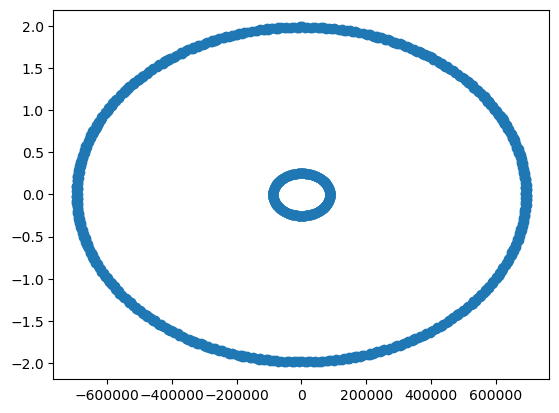

In [61]:
plt.scatter(sun_q, sun_p)